✅ CSV saved to: /home/sit/Desktop/FIFO/cubic-vs-bbr3-upload-bbr3/bbr3_vs_cubic_metrics.csv


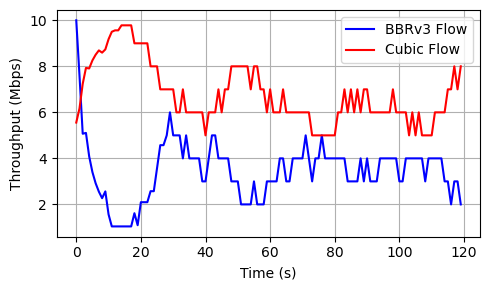

✅ Saved: /home/sit/Desktop/FIFO/cubic-vs-bbr3-upload-bbr3/mixed_algo_plots/throughput.png


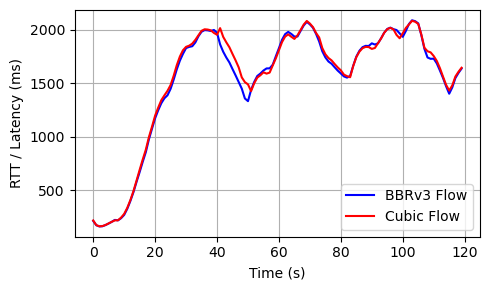

✅ Saved: /home/sit/Desktop/FIFO/cubic-vs-bbr3-upload-bbr3/mixed_algo_plots/rtt.png


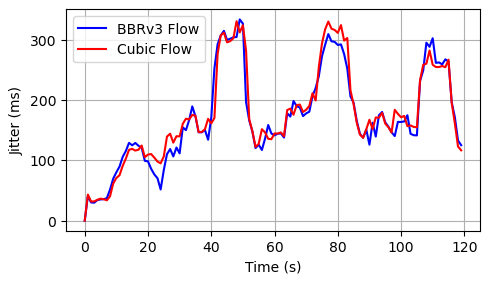

✅ Saved: /home/sit/Desktop/FIFO/cubic-vs-bbr3-upload-bbr3/mixed_algo_plots/jitter.png


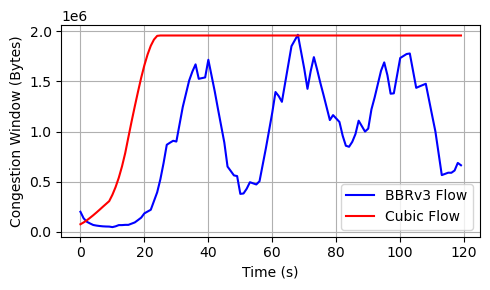

✅ Saved: /home/sit/Desktop/FIFO/cubic-vs-bbr3-upload-bbr3/mixed_algo_plots/cwnd.png


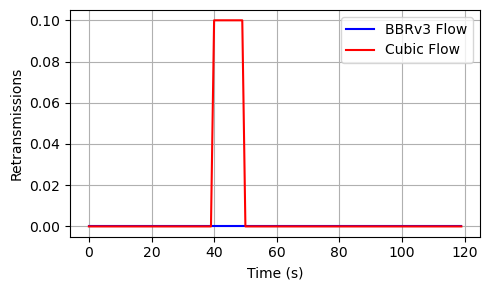

✅ Saved: /home/sit/Desktop/FIFO/cubic-vs-bbr3-upload-bbr3/mixed_algo_plots/retransmits.png


In [1]:
import json
import os
import pandas as pd
import matplotlib.pyplot as plt

def extract_metrics(filepath, label, time_offset=0):
    with open(filepath) as f:
        data = json.load(f)

    metrics = []
    prev_rtt_ms = None

    for i, interval in enumerate(data.get("intervals", [])):
        stream = interval["streams"][0]
        rtt_ms = stream.get("rtt", 0) / 1000  # Convert µs to ms
        jitter_ms = abs(rtt_ms - prev_rtt_ms) if prev_rtt_ms is not None else 0
        prev_rtt_ms = rtt_ms
        bitspersec=min(stream.get("bits_per_second", 0) / 1e6, 10)

        metrics.append({
            "time_sec": i + time_offset,  # No staggering
            "throughput_mbps": bitspersec,
            "rtt_ms": rtt_ms,
            "jitter_ms": jitter_ms,
            "cwnd_bytes": stream.get("snd_cwnd", 0),
            "retransmits": stream.get("retransmits", 0),
            "label": label
        })

    return pd.DataFrame(metrics)

def plot_metric(df, metric, ylabel, title, save_path):
    plt.figure(figsize=(5, 3))
    color_map = {
        "BBRv3 Flow": "blue",
        "Cubic Flow": "red"
    }

    for label, group in df.groupby("label"):
        color = color_map.get(label, None)
        group_sorted = group.sort_values("time_sec")
        # Apply moving average with window of 10
        smoothed = group_sorted[metric].rolling(window=10, min_periods=1).mean()
        plt.plot(group_sorted["time_sec"], smoothed, label=label, color=color)
        

    plt.xlabel("Time (s)")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()
    plt.close()
    print(f"✅ Saved: {save_path}")

def process_mixed_algos(folder_path, output_csv_name):
    all_data = []

    algo_files = {
        "BBRv3": "bbr3_flow1_1.json",
        "Cubic": "cubic_flow1_1.json"
    }

    for algo_name, filename in algo_files.items():
        filepath = os.path.join(folder_path, filename)
        label = f"{algo_name} Flow"
        if os.path.exists(filepath):
            df = extract_metrics(filepath, label)
            all_data.append(df)
        else:
            print(f"❌ File not found: {filepath}")

    if not all_data:
        print("⚠️ No data to process.")
        return

    df_all = pd.concat(all_data, ignore_index=True)

    # Save CSV
    output_csv = os.path.join(folder_path, output_csv_name)
    df_all.to_csv(output_csv, index=False)
    print(f"✅ CSV saved to: {output_csv}")

    # Create plot directory
    plot_dir = os.path.join(folder_path, "mixed_algo_plots")
    os.makedirs(plot_dir, exist_ok=True)
  
  

    # Plot metrics
    plot_metric(df_all, "throughput_mbps", "Throughput (Mbps)", "", os.path.join(plot_dir, "throughput.png"))
    plot_metric(df_all, "rtt_ms", "RTT / Latency (ms)", "", os.path.join(plot_dir, "rtt.png"))
    plot_metric(df_all, "jitter_ms", "Jitter (ms)", "", os.path.join(plot_dir, "jitter.png"))
    plot_metric(df_all, "cwnd_bytes", "Congestion Window (Bytes)", "", os.path.join(plot_dir, "cwnd.png"))
    plot_metric(df_all, "retransmits", "Retransmissions", "", os.path.join(plot_dir, "retransmits.png"))

# ----------------------------------------
# ✅ Run the function with your directory
process_mixed_algos(
    folder_path="/home/sit/Desktop/FIFO/cubic-vs-bbr3-upload-bbr3",
    output_csv_name="bbr3_vs_cubic_metrics.csv"
)


In [ ]:
# %% [markdown]
# # iPerf3 Throughput Comparison (Port 5201 Cubic vs 5202 BBR3)
#
# This notebook provides code to parse plain text iPerf3 log files, extract bitrate data, and visualize throughput over time for specific flows, with custom colors.
#
# **Instructions:**
# 1.  **Upload your iPerf3 plain text log files** (e.g., `iperf_5201_1.txt` and your file for port 5202) to your notebook environment.
# 2.  **Update the `log_files` dictionary** in the "Configuration" section below with the correct paths and labels for your files. Make sure to add the path for your 5202 BBR3 log file.
# 3.  **Run all cells** in the notebook.
#
# The plot will show throughput (bitrate) over time for each specified flow, with custom colors (red for Cubic, blue for BBR3).

# %% [python]
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os

# %% [markdown]
# ## Configuration
#
# Define the paths to your iPerf3 plain text log files and a label for each flow.
#
# **Important:**
# * Replace `'path/to/your/iperf_5202_bbr3.txt'` with the actual filename of your BBR3 flow log.
# * The labels 'Port 5201 (Cubic Flow)' and 'Port 5202 (BBR3 Flow)' are used to link to the colors.

# %% [python]
# --- Configuration ---
log_files = {
    'Port 5201 (Cubic Flow)': 'iperf_5201_1.txt',
    # !!! IMPORTANT: Replace 'path/to/your/iperf_5202_bbr3.txt' with the actual filename of your BBR3 flow log !!!
    'Port 5202 (BBR3 Flow)': 'path/to/your/iperf_5202_bbr3.txt',
}

# Units for plotting (e.g., 'Mbps' for Megabits per second, 'Gbps' for Gigabits per second)
output_unit = 'Mbps' # or 'Gbps'

# Define custom colors for the flows
flow_colors = {
    'Port 5201 (Cubic Flow)': 'red',
    'Port 5202 (BBR3 Flow)': 'blue'
}

# %% [markdown]
# ## Data Parsing and Processing

# %% [python]
def parse_iperf_log_text(file_path):
    """
    Parses a plain text iPerf3 log file to extract interval data (timestamp and bitrate).
    """
    data = []
    # Regex to match interval lines like: "[  5]   0.00-1.00   sec  1.05 MBytes  8.81 Mbits/sec"
    # It captures the end time of the interval and the bitrate value and unit.
    log_pattern = re.compile(
        r'\[\s*\d+\]\s*(?P<start_time>\d+\.\d+)-(?P<end_time>\d+\.\d+)\s+sec\s+'
        r'[\d\.]+\s*(KBytes|MBytes|GBytes)\s*(?P<bitrate_value>\d+\.\d+)\s*(?P<bitrate_unit>(K|M|G)bits/sec)'
    )

    if not os.path.exists(file_path):
        print(f"File not found: {file_path}. Skipping parsing.")
        return pd.DataFrame()

    with open(file_path, 'r') as f:
        for line in f:
            match = log_pattern.search(line)
            if match:
                end_time = float(match.group('end_time'))
                bitrate_value = float(match.group('bitrate_value'))
                bitrate_unit = match.group('bitrate_unit')

                # Convert all bitrates to bits/second for consistent processing
                if 'Kbits/sec' in bitrate_unit:
                    bitrate_bps = bitrate_value * 1e3
                elif 'Mbits/sec' in bitrate_unit:
                    bitrate_bps = bitrate_value * 1e6
                elif 'Gbits/sec' in bitrate_unit:
                    bitrate_bps = bitrate_value * 1e9
                else:
                    bitrate_bps = bitrate_value # Assume already in bits/sec if unit not matched or unknown

                data.append({'Timestamp': end_time, 'Bitrate_bps': bitrate_bps})
    return pd.DataFrame(data)

# %% [python]
all_flows_data = []

# Conversion factor for output unit
unit_factor = 1e6 if output_unit == 'Mbps' else 1e9 if output_unit == 'Gbps' else 1 # Default to bits/sec if unknown

for flow_label, file_path in log_files.items():
    print(f"Processing '{file_path}' for flow '{flow_label}'...")
    try:
        flow_df = parse_iperf_log_text(file_path)

        if not flow_df.empty:
            # Convert bitrate to desired display units
            flow_df['Bitrate_Converted'] = flow_df['Bitrate_bps'] / unit_factor
            flow_df['Flow'] = flow_label
            all_flows_data.append(flow_df)
            print(f"Successfully processed {len(flow_df)} data points from '{file_path}'.")
        else:
            print(f"No valid bitrate data found in '{file_path}'. Please check the log file format and path.")

    except Exception as e:
        print(f"An unexpected error occurred while processing '{file_path}': {e}.")

if not all_flows_data:
    print("\nNo data processed for plotting. Please check your log files and configuration.")
else:
    # Concatenate all flow data into a single DataFrame
    df_combined = pd.concat(all_flows_data, ignore_index=True)

    print("\n--- Processed Data Head ---")
    print(df_combined.head())
    print("\n--- Data Info ---")
    df_combined.info()

# %% [markdown]
# ## Plotting Bitrates Over Time

# %% [python]
if 'df_combined' in locals() and not df_combined.empty:
    plt.figure(figsize=(15, 7))

    # Create the line plot with custom colors
    sns.lineplot(
        data=df_combined,
        x='Timestamp',
        y='Bitrate_Converted',
        hue='Flow',
        palette=flow_colors, # Apply custom colors
        marker='o',
        errorbar=None
    )

    plt.title(f'iPerf3 Throughput Comparison ({output_unit})')
    plt.xlabel('Time (seconds)')
    plt.ylabel(f'Throughput ({output_unit})')
    plt.grid(True)
    plt.legend(title='Flow')
    plt.tight_layout()
    plt.show()
else:
    print("No combined DataFrame available for plotting. Ensure data processing was successful.")

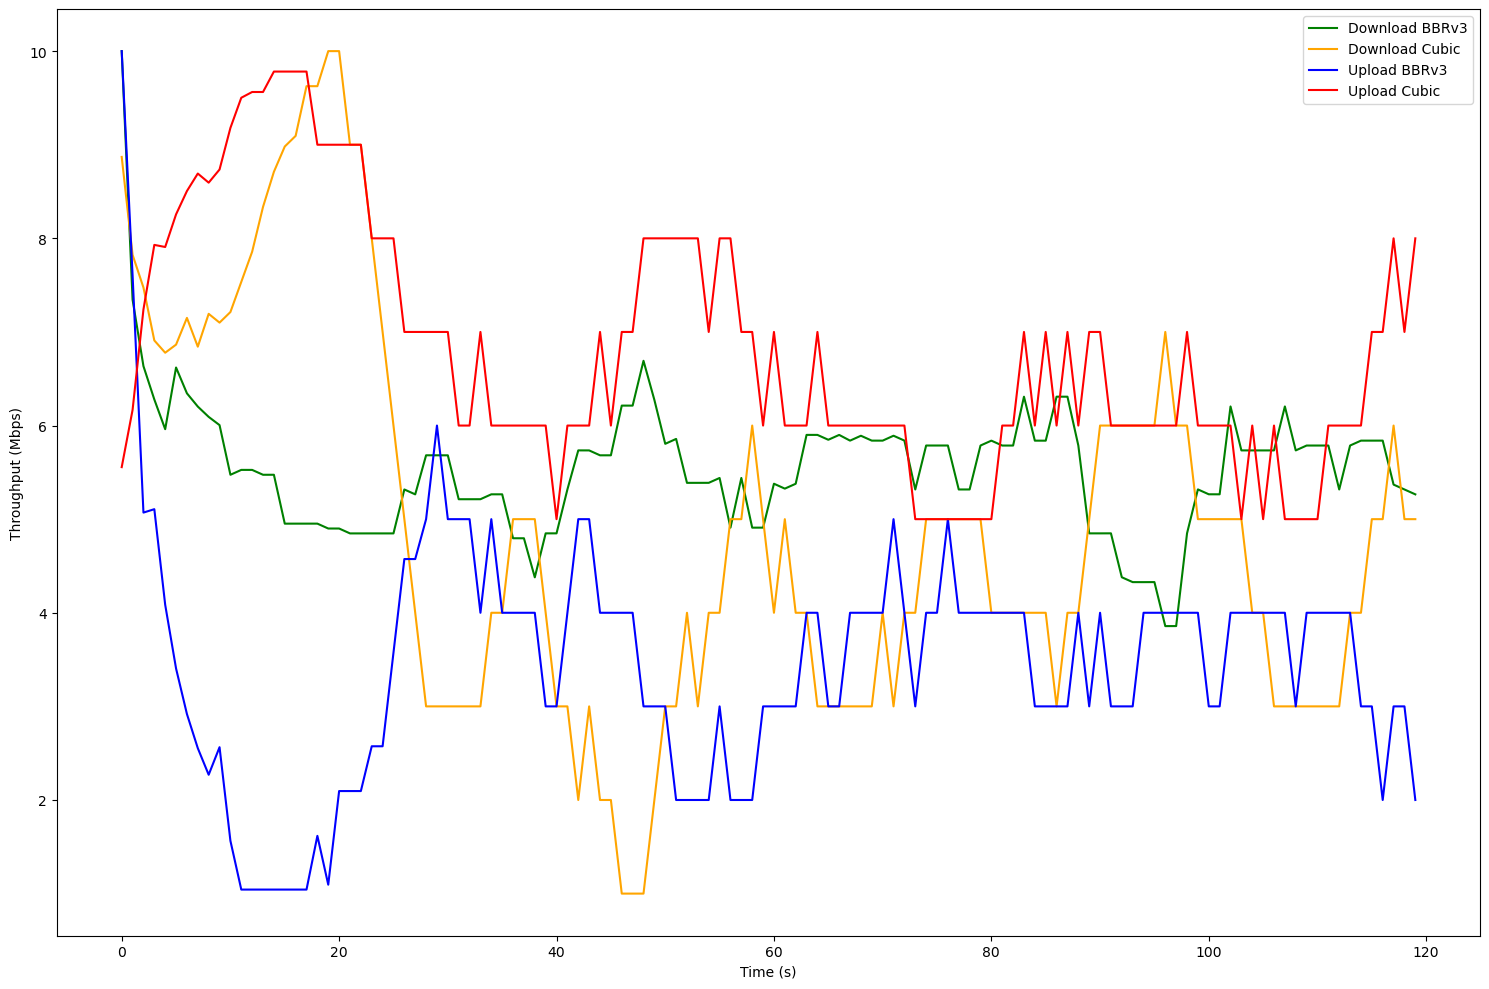

✅ Plot saved to: /home/sit/Desktop/fq/combined_plot_output/combined_throughput.png


In [53]:
import json
import os
import pandas as pd
import matplotlib.pyplot as plt

def extract_metrics(filepath, label, time_offset=0):
    with open(filepath) as f:
        data = json.load(f)

    metrics = []
    prev_rtt_ms = None

    for i, interval in enumerate(data.get("intervals", [])):
        stream = interval["streams"][0]
        rtt_ms = stream.get("rtt", 0) / 1000  # µs to ms
        jitter_ms = abs(rtt_ms - prev_rtt_ms) if prev_rtt_ms is not None else 0
        prev_rtt_ms = rtt_ms
        bitspersec = min(stream.get("bits_per_second", 0) / 1e6, 10)  # cap throughput to 10 Mbps

        metrics.append({
            "time_sec": i + time_offset,
            "throughput_mbps": bitspersec,
            "rtt_ms": rtt_ms,
            "jitter_ms": jitter_ms,
            "cwnd_bytes": stream.get("snd_cwnd", 0),
            "retransmits": stream.get("retransmits", 0),
            "label": label
        })

    return pd.DataFrame(metrics)

def load_all_data():
    scenarios = {
        "Download BBRv3": "/home/sit/Desktop/FIFO/cubic-vs-bbrv3-download/bbr3_flow1_3.json",
        "Download Cubic": "/home/sit/Desktop/FIFO/cubic-vs-bbrv3-download/cubic_flow1_3.json",
        "Upload BBRv3": "/home/sit/Desktop/FIFO/cubic-vs-bbr3-upload-bbr3/bbr3_flow1_1.json",
        "Upload Cubic": "/home/sit/Desktop/FIFO/cubic-vs-bbr3-upload-bbr3/cubic_flow1_1.json"
        
    }

    all_data = []
    for label, path in scenarios.items():
        if os.path.exists(path):
            df = extract_metrics(path, label)
            all_data.append(df)
        else:
            print(f"❌ Missing: {path}")

    if not all_data:
        raise FileNotFoundError("No data found in any scenario.")

    return pd.concat(all_data, ignore_index=True)

def plot_moving_average(df, metric, ylabel, title, save_path, window=10):
    plt.figure(figsize=(15, 10))
    color_map = {
        "Download BBRv3": "green",
        "Download Cubic": "orange",
        "Upload BBRv3": "blue",
        "Upload Cubic": "red"
    }

    for label, group in df.groupby("label"):
        color = color_map.get(label, None)
        group_sorted = group.sort_values("time_sec")
        ma = group_sorted[metric].rolling(window=window, min_periods=1).mean()
        plt.plot(group_sorted["time_sec"], ma, label=label, color=color)

    plt.xlabel("Time (s)")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    #plt.grid(True)
    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()
    plt.close()
    print(f"✅ Plot saved to: {save_path}")

# -------------- Run --------------
output_folder = "/home/sit/Desktop/fq/combined_plot_output"
os.makedirs(output_folder, exist_ok=True)

df_all = load_all_data()
plot_moving_average(
    df_all,
    metric="throughput_mbps",
    ylabel="Throughput (Mbps)",
    title="",
    save_path=os.path.join(output_folder, "combined_throughput.png"),
    window=10
)

# Optional: save CSV for record
df_all.to_csv(os.path.join(output_folder, "combined_metrics.csv"), index=False)


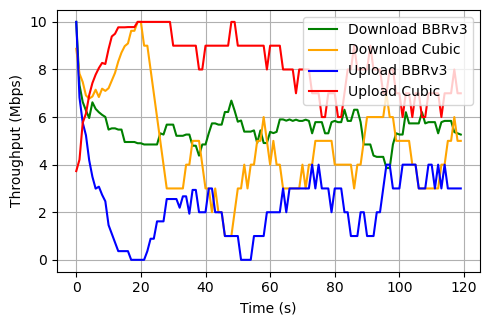

✅ Plot saved to: /home/sit/Desktop/fq/combined_plot_output/combined_throughput.png


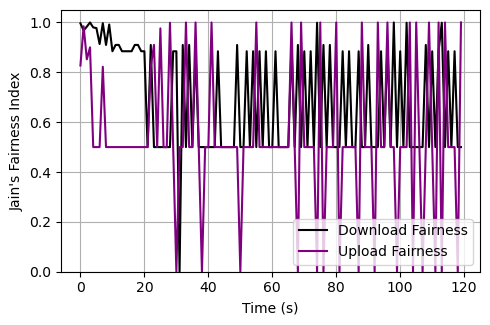

✅ Fairness plot saved to: /home/sit/Desktop/fq/combined_plot_output/fairness_index.png


In [55]:
import json
import os
import pandas as pd
import matplotlib.pyplot as plt

# -------- Extract metrics from iperf3 JSON --------
def extract_metrics(filepath, label, time_offset=0):
    with open(filepath) as f:
        data = json.load(f)

    metrics = []
    prev_rtt_ms = None

    for i, interval in enumerate(data.get("intervals", [])):
        stream = interval["streams"][0]
        rtt_ms = stream.get("rtt", 0) / 1000  # µs to ms
        jitter_ms = abs(rtt_ms - prev_rtt_ms) if prev_rtt_ms is not None else 0
        prev_rtt_ms = rtt_ms
        bitspersec = min(stream.get("bits_per_second", 0) / 1e6, 10)  # cap at 10 Mbps

        metrics.append({
            "time_sec": i + time_offset,
            "throughput_mbps": bitspersec,
            "rtt_ms": rtt_ms,
            "jitter_ms": jitter_ms,
            "cwnd_bytes": stream.get("snd_cwnd", 0),
            "retransmits": stream.get("retransmits", 0),
            "label": label
        })

    return pd.DataFrame(metrics)

# -------- Load all data from defined scenarios --------
def load_all_data():
    scenarios = {
        "Download BBRv3": "/home/sit/Desktop/FIFO/cubic-vs-bbrv3-download/bbr3_flow1_3.json",
        "Download Cubic": "/home/sit/Desktop/FIFO/cubic-vs-bbrv3-download/cubic_flow1_3.json",
        "Upload BBRv3": "/home/sit/Desktop/FIFO/cubic-vs-bbr3-upload-bbr3/bbr3_flow1_2.json",
        "Upload Cubic": "/home/sit/Desktop/FIFO/cubic-vs-bbr3-upload-bbr3/cubic_flow1_2.json"
        
    }

    all_data = []
    for label, path in scenarios.items():
        if os.path.exists(path):
            df = extract_metrics(path, label)
            all_data.append(df)
        else:
            print(f"❌ Missing: {path}")

    if not all_data:
        raise FileNotFoundError("No data found in any scenario.")

    return pd.concat(all_data, ignore_index=True)

# -------- Plot throughput with moving average --------
def plot_moving_average(df, metric, ylabel, title, save_path, window=10):
    plt.figure(figsize=(5, 3.35))
    color_map = {
        "Download BBRv3": "green",
        "Download Cubic": "orange",
        "Upload BBRv3": "blue",
        "Upload Cubic": "red"
    }

    for label, group in df.groupby("label"):
        color = color_map.get(label, None)
        group_sorted = group.sort_values("time_sec")
        ma = group_sorted[metric].rolling(window=window, min_periods=1).mean()
        plt.plot(group_sorted["time_sec"], ma, label=label, color=color)

    plt.xlabel("Time (s)")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()
    plt.close()
    print(f"✅ Plot saved to: {save_path}")

# -------- Plot Jain’s Fairness Index for Download and Upload --------
def plot_fairness_index(df, save_path):
    download_df = df[df["label"].str.contains("Download")]
    upload_df = df[df["label"].str.contains("Upload")]

    def compute_fairness(data):
        fairness_over_time = []
        for time, group in data.groupby("time_sec"):
            throughputs = group["throughput_mbps"].values
            n = len(throughputs)
            if n == 0:
                continue
            numerator = (throughputs.sum()) ** 2
            denominator = n * (throughputs ** 2).sum()
            fairness = numerator / denominator if denominator != 0 else 0
            fairness_over_time.append({"time_sec": time, "fairness_index": fairness})
        return pd.DataFrame(fairness_over_time).sort_values("time_sec")

    fairness_download = compute_fairness(download_df)
    fairness_upload = compute_fairness(upload_df)

    plt.figure(figsize=(5, 3.35))
    plt.plot(fairness_download["time_sec"], fairness_download["fairness_index"],
             label="Download Fairness", color="black")
    plt.plot(fairness_upload["time_sec"], fairness_upload["fairness_index"],
             label="Upload Fairness", color="purple")

    plt.xlabel("Time (s)")
    plt.ylabel("Jain's Fairness Index")
    plt.ylim(0, 1.05)
    plt.title("")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()
    plt.close()
    print(f"✅ Fairness plot saved to: {save_path}")

# -------------- Run Script --------------
if __name__ == "__main__":
    output_folder = "/home/sit/Desktop/fq/combined_plot_output"
    os.makedirs(output_folder, exist_ok=True)

    df_all = load_all_data()

    # Plot throughput
    plot_moving_average(
        df_all,
        metric="throughput_mbps",
        ylabel="Throughput (Mbps)",
        title="",
        save_path=os.path.join(output_folder, "combined_throughput.png"),
        window=10
    )

    # Plot fairness
    plot_fairness_index(
        df_all,
        save_path=os.path.join(output_folder, "fairness_index.png")
    )

    # Save CSV
    df_all.to_csv(os.path.join(output_folder, "combined_metrics.csv"), index=False)


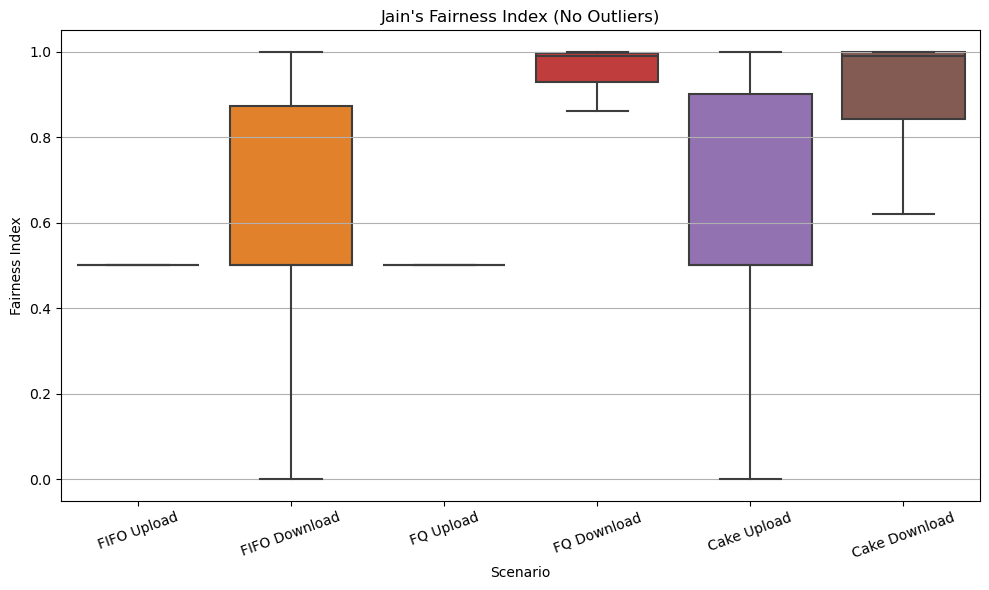

✅ Plot saved as: /home/sit/Desktop/fairness_boxplot.png


In [59]:
import json
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Function to extract throughput (in Mbps) from JSON file
def extract_throughput(filepath):
    with open(filepath) as f:
        data = json.load(f)

    throughputs = []
    for interval in data.get("intervals", []):
        stream = interval["streams"][0]
        throughput_mbps = stream.get("bits_per_second", 0) / 1e6  # Convert to Mbps
        throughputs.append(throughput_mbps)
    return throughputs

# Jain's fairness index
def jain_fairness(x, y):
    numerator = (x + y) ** 2
    denominator = 2 * (x ** 2 + y ** 2)
    return numerator / denominator if denominator != 0 else 0

# Scenario names and file paths
scenarios = {
    "FIFO Upload": (
        "/home/sit/Desktop/FIFO/cubic-vs-bbr3-upload-bbr3/cubic_flow1_2.json",
        "/home/sit/Desktop/FIFO/cubic-vs-bbr3-upload-bbr3/bbr3_flow1_2.json"
    ),
    
    "FIFO Download": (
    "/home/sit/Desktop/FIFO/cubic-vs-bbrv3-download/cubic_flow1_3.json",
    "/home/sit/Desktop/FIFO/cubic-vs-bbrv3-download/bbr3_flow1_3.json"
    ),

    
    "FQ Upload": (
        "/home/sit/Desktop/fq/bbr3-vs-cubic-upload/cubic_flow1_3.json",
        "/home/sit/Desktop/fq/bbr3-vs-cubic-upload/bbr3_flow1_3.json"
    ),
    "FQ Download": (
        "/home/sit/Desktop/fq/bbr3-vs-cubic-download-bbr3/cubic_flow1_2.json",
        "/home/sit/Desktop/fq/bbr3-vs-cubic-download-bbr3/bbr3_flow1_2.json"
    ),
    "Cake Upload": (
        "/home/sit/Desktop/Cake-plot/cubic-vs-bbr3-upload-sender-bbr/cubic_flow1_3.json",
        "/home/sit/Desktop/Cake-plot/cubic-vs-bbr3-upload-sender-bbr/bbr3_flow1_3.json"
    ),
    "Cake Download": (
        "/home/sit/Desktop/Cake-plot/cubic-vs-bbr3-download-sender-bbr/cubic_flow1_2.json",
        "/home/sit/Desktop/Cake-plot/cubic-vs-bbr3-download-sender-bbr/bbr3_flow1_2.json"
    ),
}

# Collect fairness values
fairness_data = []

for label, (path1, path2) in scenarios.items():
    if not os.path.exists(path1) or not os.path.exists(path2):
        print(f"❌ Missing file(s) for scenario: {label}")
        continue

    tp1 = extract_throughput(path1)
    tp2 = extract_throughput(path2)
    min_len = min(len(tp1), len(tp2))

    fairness_vals = [jain_fairness(tp1[i], tp2[i]) for i in range(min_len)]
    for f in fairness_vals:
        fairness_data.append({"Scenario": label, "Fairness Index": f})

# Create DataFrame
df = pd.DataFrame(fairness_data)

# Plot if data is available
if df.empty:
    print("❌ No data to plot. Please check that all JSON file paths are correct and contain data.")
else:
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df, x="Scenario", y="Fairness Index", showfliers=False)
    plt.xticks(rotation=20)
    plt.title("Jain's Fairness Index (No Outliers)")
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.savefig("/home/sit/Desktop/fairness_boxplot.png")
    plt.show()
    print("✅ Plot saved as: /home/sit/Desktop/fairness_boxplot.png")


In [ ]:
import json
import os
import pandas as pd

# Function to extract throughput (in Mbps) from JSON file
def extract_throughput(filepath):
    with open(filepath) as f:
        data = json.load(f)

    throughputs = []
    for interval in data.get("intervals", []):
        stream = interval["streams"][0]
        throughput_mbps = stream.get("bits_per_second", 0) / 1e6  # Convert to Mbps
        throughputs.append(throughput_mbps)
    return throughputs

# Jain's fairness index
def jain_fairness(x, y):
    numerator = (x + y) ** 2
    denominator = 2 * (x ** 2 + y ** 2)
    return numerator / denominator if denominator != 0 else 0

# Corrected scenario dictionary
scenarios = {
    "FIFO Upload": (
        "/home/sit/Desktop/FIFO/cubic-vs-bbr3-upload-bbr3/cubic_flow1_2.json",
        "/home/sit/Desktop/FIFO/cubic-vs-bbr3-upload-bbr3/bbr3_flow1_2.json"
    ),
    "FIFO Download": (
        "/home/sit/Desktop/FIFO/cubic-vs-bbrv3-download/cubic_flow1_3.json",
        "/home/sit/Desktop/FIFO/cubic-vs-bbrv3-download/bbr3_flow1_3.json"
    ),
    "FQ Upload": (
        "/home/sit/Desktop/fq/bbr3-vs-cubic-upload/cubic_flow1_3.json",
        "/home/sit/Desktop/fq/bbr3-vs-cubic-upload/bbr3_flow1_3.json"
    ),
    "FQ Download": (
        "/home/sit/Desktop/fQ/bbr3-vs-cubic-download-bbr3/cubic_flow1_2.json",
        "/home/sit/Desktop/fq/bbr3-vs-cubic-download-bbr3/bbr3_flow1_2.json"
    ),
    "Cake Upload": (
        "/home/sit/Desktop/Cake-plot/cubic-vs-bbr3-upload-sender-bbr/cubic_flow1_3.json",
        "/home/sit/Desktop/Cake-plot/cubic-vs-bbr3-upload-sender-bbr/bbr3_flow1_3.json"
    ),
    "Cake Download": (
        "/home/sit/Desktop/Cake-plot/cubic-vs-bbr3-download-sender-bbr/cubic_flow1_2.json",
        "/home/sit/Desktop/Cake-plot/cubic-vs-bbr3-download-sender-bbr/bbr3_flow1_2.json"
    ),
}

# Collect fairness values
fairness_summary = []

for label, (path1, path2) in scenarios.items():
    if not os.path.exists(path1) or not os.path.exists(path2):
        fairness_summary.append({"Scenario": label, "Mean Fairness": None, "Note": "File missing"})
        continue

    tp1 = extract_throughput(path1)
    tp2 = extract_throughput(path2)
    min_len = min(len(tp1), len(tp2))

    fairness_vals = [jain_fairness(tp1[i], tp2[i]) for i in range(min_len)]
    mean_fairness = sum(fairness_vals) / len(fairness_vals) if fairness_vals else None
    fairness_summary.append({"Scenario": label, "Mean Fairness": mean_fairness, "Note": "OK"})

# Create DataFrame for output
fairness_df = pd.DataFrame(fairness_summary)
fairness_df


,Scenario,Mean Fairness,Note
0,FIFO Upload,0.537419,OK
1,FIFO Download,0.667720,OK
2,FQ Upload,0.513152,OK
3,FQ Download,NaN,File missing
4,Cake Upload,0.530595,OK
5,Cake Download,0.901321,OK


✅ Saved: /home/sit/Desktop/FIFO/cubic-vs-bbr3-upload-bbr3/bbrv3_flow.csv
✅ Saved: /home/sit/Desktop/FIFO/cubic-vs-bbr3-upload-bbr3/cubic_flow.csv


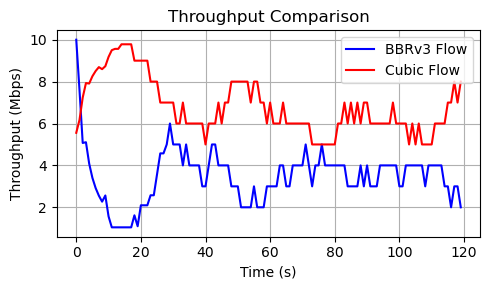

✅ Saved: /home/sit/Desktop/FIFO/cubic-vs-bbr3-upload-bbr3/plots_separate/throughput.png


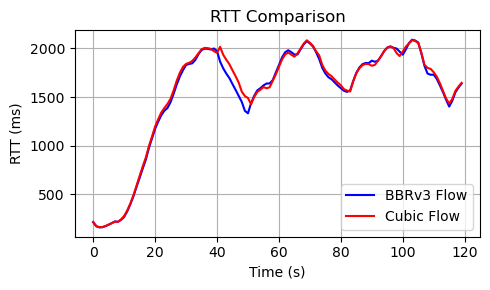

✅ Saved: /home/sit/Desktop/FIFO/cubic-vs-bbr3-upload-bbr3/plots_separate/rtt.png


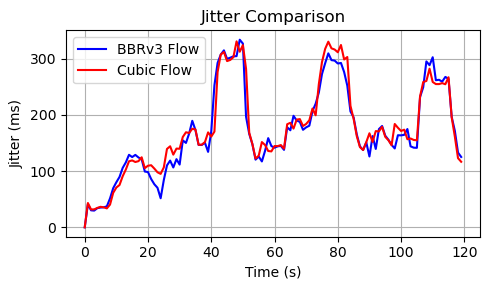

✅ Saved: /home/sit/Desktop/FIFO/cubic-vs-bbr3-upload-bbr3/plots_separate/jitter.png


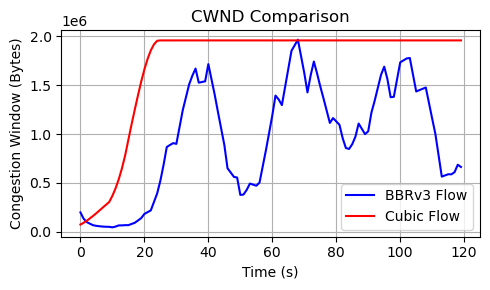

✅ Saved: /home/sit/Desktop/FIFO/cubic-vs-bbr3-upload-bbr3/plots_separate/cwnd.png


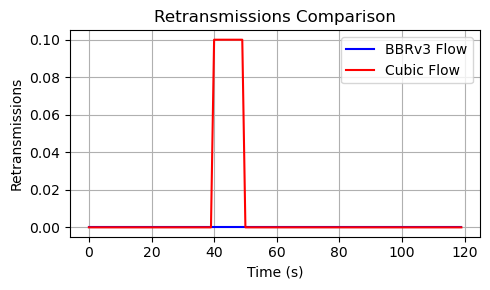

✅ Saved: /home/sit/Desktop/FIFO/cubic-vs-bbr3-upload-bbr3/plots_separate/retransmits.png


In [3]:
import json
import os
import pandas as pd
import matplotlib.pyplot as plt

def extract_metrics(filepath, label, time_offset=0):
    with open(filepath) as f:
        data = json.load(f)

    metrics = []
    prev_rtt_ms = None

    for i, interval in enumerate(data.get("intervals", [])):
        stream = interval["streams"][0]
        rtt_ms = stream.get("rtt", 0) / 1000  # Convert µs to ms
        jitter_ms = abs(rtt_ms - prev_rtt_ms) if prev_rtt_ms is not None else 0
        prev_rtt_ms = rtt_ms
        bitspersec = min(stream.get("bits_per_second", 0) / 1e6, 10)

        metrics.append({
            "time_sec": i + time_offset,
            "throughput_mbps": bitspersec,
            "rtt_ms": rtt_ms,
            "jitter_ms": jitter_ms,
            "cwnd_bytes": stream.get("snd_cwnd", 0),
            "retransmits": stream.get("retransmits", 0),
            "label": label
        })

    return pd.DataFrame(metrics)

def plot_metric(df_list, metric, ylabel, title, save_path):
    plt.figure(figsize=(5, 3))
    color_map = {
        "BBRv3 Flow": "blue",
        "Cubic Flow": "red"
    }

    for df in df_list:
        label = df['label'].iloc[0]
        color = color_map.get(label, None)
        group_sorted = df.sort_values("time_sec")
        smoothed = group_sorted[metric].rolling(window=10, min_periods=1).mean()
        plt.plot(group_sorted["time_sec"], smoothed, label=label, color=color)

    plt.xlabel("Time (s)")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()
    plt.close()
    print(f"✅ Saved: {save_path}")

def process_separate_flows(folder_path):
    flow_configs = {
        "BBRv3": "bbr3_flow1_1.json",
        "Cubic": "cubic_flow1_1.json"
    }

    df_list = []

    for algo_name, filename in flow_configs.items():
        filepath = os.path.join(folder_path, filename)
        label = f"{algo_name} Flow"
        if os.path.exists(filepath):
            df = extract_metrics(filepath, label)
            df_list.append(df)

            # Save separate CSV
            output_csv = os.path.join(folder_path, f"{algo_name.lower()}_flow.csv")
            df.to_csv(output_csv, index=False)
            print(f"✅ Saved: {output_csv}")
        else:
            print(f"❌ File not found: {filepath}")

    if not df_list:
        print("⚠️ No valid data found to plot.")
        return

    # Create plot directory
    plot_dir = os.path.join(folder_path, "plots_separate")
    os.makedirs(plot_dir, exist_ok=True)

    # Plot all metrics from individual DataFrames
    plot_metric(df_list, "throughput_mbps", "Throughput (Mbps)", "Throughput Comparison", os.path.join(plot_dir, "throughput.png"))
    plot_metric(df_list, "rtt_ms", "RTT (ms)", "RTT Comparison", os.path.join(plot_dir, "rtt.png"))
    plot_metric(df_list, "jitter_ms", "Jitter (ms)", "Jitter Comparison", os.path.join(plot_dir, "jitter.png"))
    plot_metric(df_list, "cwnd_bytes", "Congestion Window (Bytes)", "CWND Comparison", os.path.join(plot_dir, "cwnd.png"))
    plot_metric(df_list, "retransmits", "Retransmissions", "Retransmissions Comparison", os.path.join(plot_dir, "retransmits.png"))

# 🔁 Call the function with your path:
process_separate_flows(
    folder_path="/home/sit/Desktop/FIFO/cubic-vs-bbr3-upload-bbr3"
)


Fine version of PFIFO graphs for high level paper 

In [ ]:
import json
import os
import pandas as pd
import matplotlib.pyplot as plt

def extract_metrics(filepath, label, time_offset=0):
    with open(filepath) as f:
        data = json.load(f)

    metrics = []
    prev_rtt_ms = None

    for i, interval in enumerate(data.get("intervals", [])):
        stream = interval["streams"][0]
        rtt_ms = stream.get("rtt", 0) / 1000  # Convert µs to ms
        jitter_ms = abs(rtt_ms - prev_rtt_ms) if prev_rtt_ms is not None else 0
        prev_rtt_ms = rtt_ms
        bitspersec = min(stream.get("bits_per_second", 0) / 1e6, 10)

        metrics.append({
            "time_sec": i + time_offset,
            "throughput_mbps": bitspersec,
            "rtt_ms": rtt_ms,
            "jitter_ms": jitter_ms,
            "cwnd_bytes": stream.get("snd_cwnd", 0),
            "retransmits": stream.get("retransmits", 0),
            "label": label
        })

    return pd.DataFrame(metrics)

def plot_metric(df_list, metric, ylabel, title, save_path):
    plt.figure(figsize=(5, 3))
    color_map = {
        "BBRv3 Flow": "blue",
        "Cubic Flow": "red"
    }

    for df in df_list:
        label = df['label'].iloc[0]
        color = color_map.get(label, None)
        group_sorted = df.sort_values("time_sec")
        smoothed = group_sorted[metric].rolling(window=10, min_periods=1).mean()
        plt.plot(group_sorted["time_sec"], smoothed, label=label, color=color)

    plt.xlabel("Time (s)")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()
    plt.close()
    print(f"✅ Saved: {save_path}")

def process_separate_flows(folder_path):
    flow_configs = {
        "BBRv3": "bbr3_flow1_1.json",
        "Cubic": "cubic_flow1_1.json"
    }

    df_list = []

    for algo_name, filename in flow_configs.items():
        filepath = os.path.join(folder_path, filename)
        label = f"{algo_name} Flow"
        if os.path.exists(filepath):
            df = extract_metrics(filepath, label)
            df_list.append(df)

            # Save separate CSV
            output_csv = os.path.join(folder_path, f"{algo_name.lower()}_flow.csv")
            df.to_csv(output_csv, index=False)
            print(f"✅ Saved: {output_csv}")
        else:
            print(f"❌ File not found: {filepath}")

    if not df_list:
        print("⚠️ No valid data found to plot.")
        return

    # Create plot directory
    plot_dir = os.path.join(folder_path, "plots_separate")
    os.makedirs(plot_dir, exist_ok=True)

    # Plot all metrics from individual DataFrames
    plot_metric(df_list, "throughput_mbps", "Throughput (Mbps)", "Throughput Comparison", os.path.join(plot_dir, "throughput.png"))
    plot_metric(df_list, "rtt_ms", "RTT (ms)", "RTT Comparison", os.path.join(plot_dir, "rtt.png"))
    plot_metric(df_list, "jitter_ms", "Jitter (ms)", "Jitter Comparison", os.path.join(plot_dir, "jitter.png"))
    plot_metric(df_list, "cwnd_bytes", "Congestion Window (Bytes)", "CWND Comparison", os.path.join(plot_dir, "cwnd.png"))
    plot_metric(df_list, "retransmits", "Retransmissions", "Retransmissions Comparison", os.path.join(plot_dir, "retransmits.png"))

# 🔁 Call the function with your path:
process_separate_flows(
    folder_path="/home/sit/Desktop/FIFO/cubic-vs-bbr3-upload-bbr3"
)


✅ Saved: /home/sit/Desktop/pfifo/PFIFO_45/bbr-vs-bbr2-vs-bbr3-vs-cubic/bbrv1_flow.csv
✅ Saved: /home/sit/Desktop/pfifo/PFIFO_45/bbr-vs-bbr2-vs-bbr3-vs-cubic/bbrv2_flow.csv
✅ Saved: /home/sit/Desktop/pfifo/PFIFO_45/bbr-vs-bbr2-vs-bbr3-vs-cubic/bbrv3_flow.csv
✅ Saved: /home/sit/Desktop/pfifo/PFIFO_45/bbr-vs-bbr2-vs-bbr3-vs-cubic/cubic_flow.csv


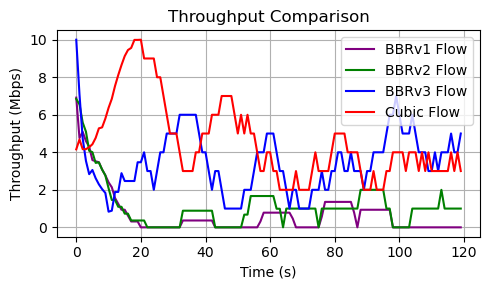

✅ Saved: /home/sit/Desktop/pfifo/PFIFO_45/bbr-vs-bbr2-vs-bbr3-vs-cubic/plots_comparison/throughput.png


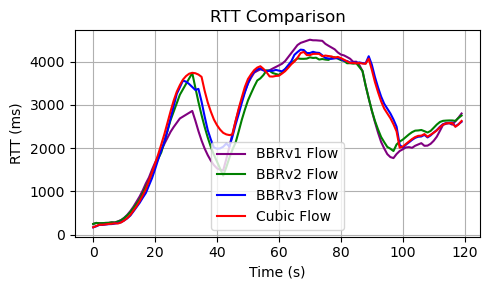

✅ Saved: /home/sit/Desktop/pfifo/PFIFO_45/bbr-vs-bbr2-vs-bbr3-vs-cubic/plots_comparison/rtt.png


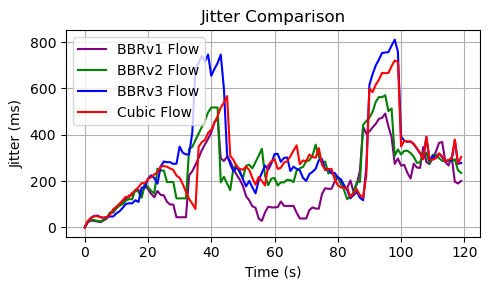

✅ Saved: /home/sit/Desktop/pfifo/PFIFO_45/bbr-vs-bbr2-vs-bbr3-vs-cubic/plots_comparison/jitter.png


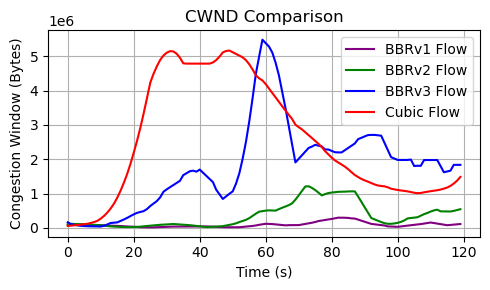

✅ Saved: /home/sit/Desktop/pfifo/PFIFO_45/bbr-vs-bbr2-vs-bbr3-vs-cubic/plots_comparison/cwnd.png


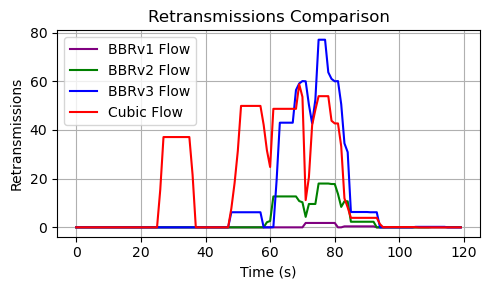

✅ Saved: /home/sit/Desktop/pfifo/PFIFO_45/bbr-vs-bbr2-vs-bbr3-vs-cubic/plots_comparison/retransmits.png


In [1]:
import json
import os
import pandas as pd
import matplotlib.pyplot as plt

def extract_metrics(filepath, label, time_offset=0):
    with open(filepath) as f:
        data = json.load(f)

    metrics = []
    prev_rtt_ms = None

    for i, interval in enumerate(data.get("intervals", [])):
        stream = interval["streams"][0]
        rtt_ms = stream.get("rtt", 0) / 1000  # Convert µs to ms
        jitter_ms = abs(rtt_ms - prev_rtt_ms) if prev_rtt_ms is not None else 0
        prev_rtt_ms = rtt_ms
        bitspersec = min(stream.get("bits_per_second", 0) / 1e6, 10)

        metrics.append({
            "time_sec": i + time_offset,
            "throughput_mbps": bitspersec,
            "rtt_ms": rtt_ms,
            "jitter_ms": jitter_ms,
            "cwnd_bytes": stream.get("snd_cwnd", 0),
            "retransmits": stream.get("retransmits", 0),
            "label": label
        })

    return pd.DataFrame(metrics)

def plot_metric(df_list, metric, ylabel, title, save_path):
    plt.figure(figsize=(5, 3))
    color_map = {
        "BBRv1 Flow": "purple",
        "BBRv2 Flow": "green",
        "BBRv3 Flow": "blue",
        "Cubic Flow": "red"
    }

    for df in df_list:
        label = df['label'].iloc[0]
        color = color_map.get(label, None)
        group_sorted = df.sort_values("time_sec")
        smoothed = group_sorted[metric].rolling(window=10, min_periods=1).mean()
        plt.plot(group_sorted["time_sec"], smoothed, label=label, color=color)

    plt.xlabel("Time (s)")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()
    plt.close()
    print(f"✅ Saved: {save_path}")

def process_all_flows(folder_path):
    flow_configs = {
        "BBRv1": "bbr_results_1.json",
        "BBRv2": "bbr2_results_1.json",
        "BBRv3": "bbr3_results_1.json",
        "Cubic": "cubic_results_1.json"
    }

    df_list = []

    for algo_name, filename in flow_configs.items():
        filepath = os.path.join(folder_path, filename)
        label = f"{algo_name} Flow"
        if os.path.exists(filepath):
            df = extract_metrics(filepath, label)
            df_list.append(df)

            # Save CSV
            output_csv = os.path.join(folder_path, f"{algo_name.lower()}_flow.csv")
            df.to_csv(output_csv, index=False)
            print(f"✅ Saved: {output_csv}")
        else:
            print(f"❌ File not found: {filepath}")

    if not df_list:
        print("⚠️ No valid data found to plot.")
        return

    # Create plot directory
    plot_dir = os.path.join(folder_path, "plots_comparison")
    os.makedirs(plot_dir, exist_ok=True)

    # Plot all metrics
    plot_metric(df_list, "throughput_mbps", "Throughput (Mbps)", "Throughput Comparison", os.path.join(plot_dir, "throughput.png"))
    plot_metric(df_list, "rtt_ms", "RTT (ms)", "RTT Comparison", os.path.join(plot_dir, "rtt.png"))
    plot_metric(df_list, "jitter_ms", "Jitter (ms)", "Jitter Comparison", os.path.join(plot_dir, "jitter.png"))
    plot_metric(df_list, "cwnd_bytes", "Congestion Window (Bytes)", "CWND Comparison", os.path.join(plot_dir, "cwnd.png"))
    plot_metric(df_list, "retransmits", "Retransmissions", "Retransmissions Comparison", os.path.join(plot_dir, "retransmits.png"))

# 🔁 Run the function
process_all_flows(
    folder_path="/home/sit/Desktop/pfifo/PFIFO_45/bbr-vs-bbr2-vs-bbr3-vs-cubic"
)
